# Seq2Seq Model for Text Simplification

---
In this notebook, I will walk through the process of training a Bi-directional Seq2Seq model w/ attention mechanism for text simplification.

---
## Import & Configure
There are quite a few libraries used here. Mainly we rely on keras, and will limit use of other non-standard libraries.

In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

import string
import pickle
import operator

from sklearn.model_selection import train_test_split

%matplotlib inline

In [376]:
from keras.layers import Input, LSTM, Embedding, Dense, RepeatVector
from keras.layers import GRU, TimeDistributed, Bidirectional, merge
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import plot_model, np_utils
from keras.initializers import Constant

We define some hyperparameters in processing our variables here, such as the number of samples we want held back for validation and testing, as well as the dimensionality of our embedded vectors.

In [377]:
num_train_samples = 100_000
num_val_samples = 10_000
embedding_dim = 100
learning_rate = 0.01
n_units = 128
vocab_size = 30_000
batch_size = 64
epochs = 100
max_seq_len = 100

We read in the data below and get a quick look at it.

In [378]:
normal = pd.read_csv('../data/sentence-aligned.v2/normal.aligned',sep='\t',header=None)
normal.head()

,0,1,2
0,"Cherokee, Oklahoma",0,It is the county seat of Alfalfa County .
1,"Cherokee, Oklahoma",0,"Cherokee is a city in Alfalfa County , Oklahom..."
2,Skateboard,5,Skateboard decks are usually between 28 and 33...
3,Skateboard,5,The underside of the deck can be printed with ...
4,Skateboard,6,This was created by two surfers ; Ben Whatson ...


In [379]:
simple = pd.read_csv('../data/sentence-aligned.v2/simple.aligned',sep='\t',header=None)
simple.head()

,0,1,2
0,"Cherokee, Oklahoma",0,It is the county seat of Alfalfa County .
1,"Cherokee, Oklahoma",0,Cherokee is a city of Oklahoma in the United S...
2,Skateboard,2,Skateboard decks are normally between 28 and 3...
3,Skateboard,2,The bottom of the deck can be printed with a d...
4,Skateboard,3,The longboard was made by two surfers ; Ben Wh...


---
## Text preprocessing
The idea here is to get the text into a format usable by our neural networks, and generally tidying up a bit.

In [380]:
# Remove instances where Simple Wikipedia and Wikipedia sentences are identical.
identical_filter = (normal[2] != simple[2])

# Define a regex pattern used to remove some wikipeida formatting artefacts.
# pattern = r'(-lrb-)(?<=-lrb-)(.*?)(?=-rrb-)(-rrb-)'
pattern = '-lrb-.*?-rrb-'

# Select the column of the 'normal' dataframe with the relevant data.
normal_sentences = normal[2][identical_filter]

# For each sentence, we want to try to remove string artefacts from wikipedia, usually as a result of hyperlinks
# These can greatly increase the size of our sequences, needlessly, and are also noise.
input_texts=[]
input_vocab=set()
for text in normal_sentences:
    text = text.lower()
    matches = re.findall(pattern,text)
    for match in matches:
        match = "".join(match)
        text = text.replace(match,"")
    sentence = f'{text}'.split(' ')
    input_texts.append(sentence)
    
    # Add unique words to vocabulary
    for word in sentence:
        if word not in input_vocab:
            input_vocab.add(word)


# Define beginning of sentence and end of sentence tokens.
# These will allow us to initialize our decoder layer and also allow it to know when to stop.
bos='bos '
eos=' eos'

# Do the same for sentences from simplified wikipedia.
simplified_sentences = simple[2][identical_filter]
target_texts=[]
target_vocab=set()
for text in normal_sentences:
    text = text.lower()
    matches = re.findall(pattern,text)
    for match in matches:
        match = "".join(match)
        text = text.replace(match,"")
    sentence = f'{bos}{text}{eos}'.split(' ')
    target_texts.append(sentence)
    for word in sentence:
        if word not in target_vocab:
            target_vocab.add(word)
    
print(f'No. pairs before preprocessing: {len(normal[2])}')
print(f'No. pairs after preprocessing: {len(input_texts)}')

No. pairs before preprocessing: 167689
No. pairs after preprocessing: 117952


Let's take a look at the longest sentence we have in our database. That's pretty dang long.

In [381]:
seqs = [len(seq) for seq in input_texts]
" ".join(input_texts[seqs.index(max(seqs))])

"asiatic cheetah  has for a long time been theoretically classified as a sub-species of the cheetah with the suffix `` venaticus '' applied at the end of its scientific binomial name acinonyx jubatus but at a cheetah reintroduction workshop organized in india on 9 september 2009 stephen j. o'brien from laboratory of genomic diversity of national cancer institute , usa who has in the past conducted numerous prestigious genetic studies including those on asiatic lions said that according to latest modern genetic studies which became possible only now it was discovered that in fact asiatic cheetah was genetically identical to the african cheetah with which it had separated only about 5000 years ago which was not enough time for a sub-species level differentiation , in comparison he said that the asian and african lion subspecies were separated some 100,000 years ago , so was the african and asian leopard subspecies 169,000 years ago . cheetah expert laurie marker of the cheetah conservati

# Save Cleaned Data

In [492]:
input_train,input_test,target_train,target_test = train_test_split(input_texts,target_texts,random_state=42,test_size=validation_split,shuffle=True)

---
## Tokenizing
Tokenizing is the process of representing words with integers indicating their position in a vocabulary.

In [217]:
# Instantiate a tokenizer, and determine the size of the vocabulary for our data.
# Words outside of our vocabular are replaced by the token 'unk', referring to unkown.
tokenizer = Tokenizer(num_words=vocab_size,oov_token='unk')
tokenizer.fit_on_texts(input_texts)
vocabulary = tokenizer.word_index

# Convert the sentences into sequences of integers representing the location of the words in the vocabulary
input_integer_sequences = tokenizer.texts_to_sequences(input_texts)
target_integer_sequences = tokenizer.texts_to_sequences(target_texts)
input_len_seqs = [len(seq) for seq in input_integer_sequences]
target_len_seqs = [len(seq) for seq in target_integer_sequences]

max_input_seq_len = max(input_len_seqs)
print(f'Longest input sequence length: {max_input_seq_len}')
max_target_seq_len = max(target_len_seqs)
print(f'Longest target sequence length: {max_target_seq_len}')

Longest input sequence length: 222
Longest target sequence length: 224


222 and 224 is quite long; the sentence earlier regarding asiatic cheetahs, although interesting, is not the norm. Let's take a look at the distribution of the lengths of our sentences.

In [121]:
# We take the mean plus two standard deviations of our sentence length
max_seq_len = np.mean(input_len_seqs) + 2 * np.std(input_len_seqs)
max_seq_len = int(max_seq_len)

In [122]:
# Choose a cutoff length for our data. This is mainly to prevent the burden on my computer form being unbearable
in_above=len([seq for seq in input_len_seqs if seq>=max_seq_len])
tar_above=len([seq for seq in target_len_seqs if seq>=max_seq_len])

print(f'Average regular wikipedia sentence length:\n{round(np.mean(input_len_seqs),1)} tokens')
print(f'Average simplified wikipedia sentence length:\n{round(np.mean(target_len_seqs),1)} tokens')
print(f'Number of regular wikipedia sentences longer than {max_seq_len} tokens:\n{in_above}, or {round(100*in_above/len(input_texts),2)}%')
print(f'Number of simplified wikipedia sentences longer than {max_seq_len} tokens:\n{tar_above}, or {round(100*tar_above/len(input_texts),2)}%')

Average regular wikipedia sentence length:
25.7 tokens
Average simplified wikipedia sentence length:
27.7 tokens
Number of regular wikipedia sentences longer than 52 tokens:
5696, or 4.83%
Number of simplified wikipedia sentences longer than 52 tokens:
6718, or 5.7%


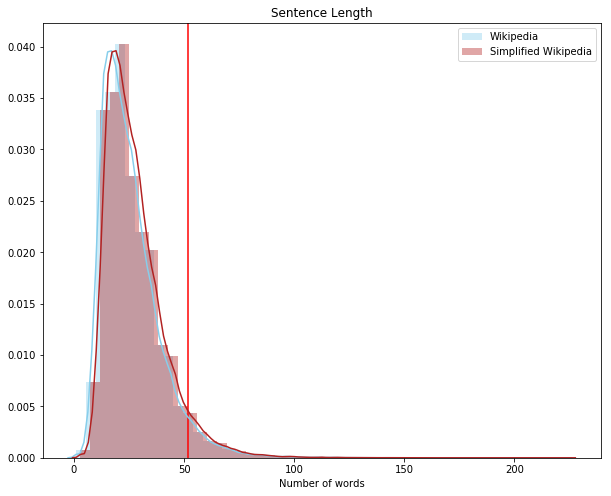

In [123]:
plt.figure(figsize=(10,8))
plt.title("Sentence Length")
plt.xlabel("Number of words")
plt.axvline(max_seq_len,color='r')
sns.distplot(input_len_seqs,color='skyblue',label="Wikipedia")
sns.distplot(target_len_seqs,color='firebrick',label="Simplified Wikipedia")
plt.legend()

In [124]:
# In this step we pad shorter sequences to be 52 tokens long
# We also truncate longer sequences to fit the format

input_integer_sequences = pad_sequences(
    input_integer_sequences,
    value=0,
    maxlen=max_seq_len,
    padding='post',
    truncating='post'
)
target_integer_sequences = pad_sequences(
    target_integer_sequences,
    value=0,
    maxlen=max_seq_len,
    padding='post',
    truncating='post'
)

---
## Embedding
The purpose of embedding is to try and find a lower dimension representation of each of the words in our corpus. We can train our own, or we can use pre-trained vectors.

In [125]:
embeddings_dict = dict()
f = open('../data/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_dict[word] = coefs
f.close()
print(f'Loaded {len(embeddings_dict)} word vectors')
embedding_matrix = np.zeros((vocab_size,100))
for word,i in vocabulary.items():
    if i > vocab_size-1:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400001 word vectors


In [374]:
embeddings_dict['eos']

array([-0.66432 ,  0.012997,  0.01181 , -0.084488, -0.78247 ,  1.1457  ,
        0.25839 , -0.6626  , -1.1347  , -0.83052 ,  1.4438  , -0.17832 ,
        0.52204 ,  0.087625,  0.098307, -0.70804 ,  0.058561,  0.40312 ,
        0.72853 ,  0.15914 ,  0.0672  ,  0.016688, -0.52523 ,  0.85851 ,
        0.85145 , -0.11051 ,  1.0307  , -0.17542 , -0.2927  , -0.59956 ,
       -0.24308 ,  1.2302  , -0.81797 ,  0.46934 ,  0.20564 , -0.25792 ,
        0.77917 , -0.60109 ,  1.4014  , -0.5972  , -0.40991 ,  0.38727 ,
        0.027353, -0.054872, -0.17931 , -0.99247 ,  0.27762 , -0.20651 ,
       -0.72933 ,  0.35249 , -0.089301,  0.81046 ,  0.95734 , -0.49469 ,
       -0.41374 ,  0.71049 , -0.8651  ,  1.2328  ,  0.14062 , -1.0762  ,
        0.45116 ,  0.20948 , -0.49114 , -0.091184, -1.1643  ,  0.3087  ,
       -0.78891 , -0.50382 , -0.089517,  0.44128 ,  0.83588 , -0.089127,
        0.31822 , -0.59513 , -0.28502 , -1.7288  , -0.69524 , -0.023866,
       -0.7321  , -0.5406  ,  0.081562,  0.063065, 

---
## Batching & Model Building
Since I'm handling this data on an old 2013 MacBook Pro, I have to maintain relatively small batch sizes.

In [126]:
train_input = input_integer_sequences[:100_000]
train_target = target_integer_sequences[:100_000]

test_input = input_integer_sequences[100_001:110_000]
test_target = target_integer_sequences[100_001:110_000]

batch_indices = range(0,100_000,100)

In [339]:
dictionary = zip(vocabulary.values(),vocabulary.keys())

## Functional Model

In [128]:
for batch_idx in batch_indices[0:1]:
    input_seqs = input_integer_sequences[batch_idx:(batch_idx+100)]
    target_seqs = target_integer_sequences[batch_idx:(batch_idx+100)]
    encoder_input = np.zeros(
        (len(input_seqs),max_seq_len,vocab_size),
        dtype='float32'
    )
    decoder_input = np.zeros(
        (len(input_seqs),max_seq_len,vocab_size),
        dtype='float32'
    )
    decoder_target = np.zeros(
        (len(input_seqs),max_seq_len,vocab_size),
        dtype='int32'
    )
    for i, (input_seq, target_seq) in enumerate(zip(input_seqs,target_seqs)):
        for t, w in enumerate(input_seq):
            encoder_input[i, t, w] = 1.
        for t, w in enumerate(target_seq):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input[i, t, w] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target[i, t - 1, w] = 1.
    # define training encoder
    encoder_inputs = Input(shape=(None, embedding_dim))
    encoder = LSTM(n_units, return_state=True) # Bidirectional here
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, embedding_dim))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(embedding_dim, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# decoder_target_data = np.zeros(
#     (batch_size,max_seq_len,vocab_size)
# )
# for i, seqs in enumerate():
#     for j,seq in enumerate(seqs):
#         if j>0: # Input is ahead of target by one timestep.
#             decoder_target_data[i][j][seq] = 1

# # The input to the decoder is one word removed from the target of the decoder
# encoder_input_data = np.zeros(
#     (len(input_texts),max_seq_len),
#     dtype='float32'
# )
# decoder_input_data = np.zeros(
#     (len(target_texts),max_seq_len),
#     dtype='float32'
# )
# decoder_target_data = np.zeros(
#     (len(target_texts),max_seq_len,vocab_size)
# )

## Sequential??

In [ ]:
learning_rate=1e-3
model = Sequential()
model.add(Bidirectional(GRU(128,input_shape=(max_encoder_seq_length,),return_sequences=False)))
model.add(RepeatVector(max_decoder_length))
model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(TimeDistributed(Dense(len(target_words),activation='softmax')))

# Scratchpad Below This

In [382]:
# A wrapper for keras' tokenizer class which provides some much needed functionality.
# Code from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    def __init__(self, texts, padding,
                 reverse=False, num_words=None,oov_token=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """
        Tokenizer.__init__(self, num_words=num_words,oov_token=oov_token)
        self.fit_on_texts(texts)
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
        self.tokens = self.texts_to_sequences(texts)
        if reverse:
            self.tokens = [list(reversed(x)) for x in self.tokens]
            truncating = 'pre'
        else:
            truncating = 'post'
        self.num_tokens = [len(x) for x in self.tokens]
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)
    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""
        word = " " if token == 0 else self.index_to_word[token]
        return word 
    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        text = " ".join(words)
        return text
    def text_to_tokens(self, text, reverse=False, padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)
        if reverse:
            tokens = np.flip(tokens, axis=1)
            truncating = 'pre'
        else:
            truncating = 'post'
        if padding:
            tokens = pad_sequences(tokens,maxlen=self.max_tokens,
                                   padding='pre',
                                   truncating=truncating)
        return tokens

In [383]:
%%time
input_tokenizer = TokenizerWrap(texts=input_texts,
                                padding='pre',
                                reverse=True,
                                num_words=vocab_size,
                                oov_token='unk')

CPU times: user 5.9 s, sys: 164 ms, total: 6.06 s
Wall time: 6.13 s


In [384]:
inputs_tokenized = input_tokenizer.tokens_padded

In [385]:
inputs_tokenized.shape

(117952, 52)

In [386]:
target_tokenizer = TokenizerWrap(texts=target_texts,
                                padding='post',
                                reverse=False,
                                num_words=vocab_size,
                                oov_token='unk')

In [387]:
targets_tokenized = target_tokenizer.tokens_padded

In [388]:
targets_tokenized.shape

(117952, 54)

In [389]:
encoder_input_data = inputs_tokenized
decoder_input_data = targets_tokenized[:,:-1]

In [390]:
decoder_input_data.shape

(117952, 53)

In [391]:
decoder_output_data = targets_tokenized[:,1:]
decoder_output_data.shape

(117952, 53)

In [392]:
embeddings_dict = {}
f = open('../data/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_dict[word] = coefs
f.close()
print(f'Loaded {len(embeddings_dict)} word vectors')

Loaded 400001 word vectors


In [393]:
input_embed_matrix = np.zeros((vocab_size,embedding_dim))
for word, i in input_tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    vec = embeddings_dict.get(word)
    if vec is not None:
        input_embed_matrix[i] = vec

In [394]:
target_embed_matrix = np.zeros((vocab_size,embedding_dim))
for word, i in target_tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    vec = embeddings_dict.get(word)
    if vec is not None:
        target_embed_matrix[i] = vec

In [480]:
encoder_input = Input(shape=(None,),name='encoder_input')
encoder_embedding = Embedding(
    input_dim = vocab_size,
    output_dim = embedding_dim,
    embeddings_initializer=Constant(input_embed_matrix),
    trainable = False,
    name='encoder_embedding')
# encoder_birnn = Bidirectional(GRU(units=n_units,return_sequences=True))
encoder_birnn = GRU(units=n_units,return_sequences=True)


def connect_encoder():
    net = encoder_input
    net = encoder_embedding(net)
    net = encoder_birnn(net)
    encoder_output = net
    return encoder_output

# encoder_output = encoder_birnn(encoder_embedding(encoder_input))

In [481]:
encoder_output = connect_encoder()

In [482]:
decoder_initial_state = Input(shape=(n_units,),name='decoder_initial_state')
decoder_input = Input(shape=(None,),name='decoder_input')
decoder_embedding = Embedding(
    input_dim = vocab_size,
    output_dim = embedding_dim,
    embeddings_initializer=Constant(target_embed_matrix),
    trainable = False,
    name='decoder_embedding')
decoder_rnn = GRU(units=n_units,return_sequences=True)
decoder_dense = Dense(vocab_size,activation='linear',name='decoder_output')

def connect_decoder(initial_state):
    net = decoder_input
    net = decoder_embedding(net)
    net = decoder_rnn(net,initial_state=initial_state)
    decoder_output = decoder_dense(net)
    return decoder_output

# decoder_output = decoder_dense(decoder_rnn(decoder_embedding(decoder_input),initial_state=encoder_output))

In [483]:
decoder_output = connect_decoder(initial_state=encoder_output)

In [484]:
model_train = Model(inputs=[encoder_input,decoder_input],
                    outputs=[decoder_output])

model_encoder = Model(inputs=[encoder_input],
                      outputs=[encoder_output])
decoder_output = connect_decoder(initial_state = decoder_initial_state)
model_decoder = Model(inputs=[decoder_input,decoder_initial_state],
                      outputs=[decoder_output])

In [485]:
model_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 100)    3000000     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 100)    3000000     decoder_input[0][0]              
__________________________________________________________________________________________________
gru_32 (GR

In [469]:
import tensorflow as tf

In [488]:
decoder_target = tf.placeholder(dtype='float32', shape=(None, None))

In [489]:
model.compile(optimizer='rmsprop',
              loss=sparse_cross_entropy,
              target_tensors=[decoder_target],
              metrics=['acc'])

TypeError: Input 'y' of 'Equal' Op has type float32 that does not match type int32 of argument 'x'.

In [472]:
path_checkpoint = 'capstone_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./capstone_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard]

In [473]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'capstone_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [474]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [475]:
y_data = \
{
    'decoder_output': decoder_output_data
}

In [476]:
validation_split = 10000/len(encoder_input_data)

In [477]:
validation_split

0.0847802495930548

In [478]:
model.fit(
    x=[encoder_input_data,decoder_input_data],
    y=[decoder_output_data],
    batch_size=64,
    epochs=2,
    callbacks=callbacks,
    validation_split=validation_split
)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[    0,     0,     0, ...,     8,     9,  7190],
       [    0,     0,     0, ...,    26, 22331, 22330],
       [    0,     0,     0, ...,     5,  7359,     2],
       ...,
       [    0,     ...

In [ ]:
train_input = input_integer_sequences[:100_000]
train_target = target_integer_sequences[:100_000]

test_input = input_integer_sequences[100_001:110_000]
test_target = target_integer_sequences[100_001:110_000]

batch_indices = range(0,100_000,100)

In [495]:
for batch_idx in batch_indices[0:1]:
    train_encoder_input = np.array(train_encoder_input_data[batch_idx:(batch_idx+100)])
    train_decoder_input = np.array(train_decoder_input_data[batch_idx:(batch_idx+100)])
    train_decoder_output= np.array(train_decoder_output_data[batch_idx:(batch_idx+100)])
    model.fit([train_encoder_input, train_decoder_input], train_decoder_target,
          batch_size=,
          epochs=epochs,
        )

SyntaxError: invalid syntax (<ipython-input-495-2a79a417f827>, line 6)

NameError: name 'decoder_target_data' is not defined